In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import pdfplumber
import tabula
import seaborn as sns
from Olympic_PED_use.src import functions as fn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from bs4 import BeautifulSoup
import certifi
import urllib3
import re
from csv import DictReader, DictWriter
import datetime as dt

In [83]:
import glob

In [3]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000000)

#### Loading in a dataframe containing the annual count of doping cases per country from 1998-2012

In [488]:
url = 'https://olympstats.com/2019/01/18/all-olympic-doping-positives-the-count-by-games/'
req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                         ca_certs=certifi.where())
res = req.request('GET', url)
soup = BeautifulSoup(res.data, 'html.parser')
contents = soup.find_all(class_= 'table-responsive')    
ped_by_country_df = pd.read_html(str(contents))[0]
ped_by_country_df.columns = ['year', 'city', 'count']
ped_by_country_df

,year,city,count
0,2012.0,London,121
1,2008.0,Beijing,86
2,2000.0,Sydney,42
3,2004.0,Athínai,41
4,2006.0,Torino,19
5,2016.0,Rio de Janeiro,17
6,1996.0,Atlanta,13
7,1984.0,Los Angeles,12
8,2014.0,Sochi,12
9,1976.0,Montréal,11


<AxesSubplot:ylabel='city'>

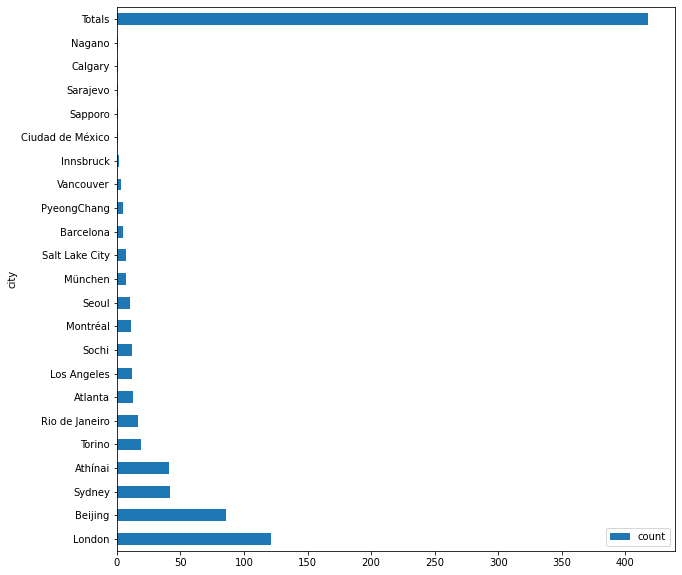

In [498]:
ped_by_country_df.plot('city', 'count', kind='barh', figsize=(10,10))

In [4]:
def olympedia_scraper(content):
    a = []
    b = []
    c = []
    d = []
    e = []

    tables = []
    for table in content:
        tables.append(table)
        for table_ in tables:
            rows = table_.find_all('tr')
            for row in rows:
                cells = row.find_all('td')
                if len(cells) == 7:
                    a.append(cells[0].text)
                    b.append(cells[1].text)
                    c.append(cells[2].text)
                    d.append(cells[3].text)
                    e.append(cells[4].text)

    df = pd.DataFrame(a, columns=['id'])
    df['name'] = b
    df['nationality'] = c
    df['sport'] = d
    df['era'] = e

    
    return df

In [141]:
def create_athlete_df():
   
    dfs = []
    csvs = glob.glob('../data/athletes_by_event/*')
    for csv in csvs:
        #print('loading_csv:{}'.format(csv))
        df_ = pd.read_csv(csv, delimiter='\t', keep_default_na=False)
        df_ = df_.drop('Unnamed: 5', axis=1)
        dfs.append(df_)
    if len(dfs) == 40:
        print('finished')
    df = dfs[0]
    for x in range(len(dfs)-1):
        
        df = df.append(dfs[x])
    
    df.columns = [x.lower() for x in df.columns]
    df.name = [x.title() for x in df.name]
    
    df = df.sort_values(by='name')
    
    return df

In [301]:
def create_doping_df():
    doping_dfs = tabula.read_pdf('../data/datasets/July-2020-Sanctions-List-Full.pdf', pages='all',
                     output_format='dataframe')
    df = doping_dfs[0]
    for x in range(len(doping_dfs)-1):
        df = df.append(doping_dfs[x])
    df.columns = ['name', 'dob', 'nationality', 'roll',
                 'sex', 'discipline_1', 'discipline_2', 
                 'date_of_infraction', 'sanction', 
                 'ineligibility_until', 'dq_date', 
                 'lifetime_ban', 'infraction_type', 
                 'adrv_rules', 'adrv_notes', 'description']
    
    df = df[df['infraction_type'] == 'Doping']
    df = df.rename(columns={'infraction_type':'flagged'})
    df.name = [x.title() for x in df.name]
    df.name = [x.strip(',') for x in df.name]
    
    df.dq_date = df.dq_date.fillna(value='0')
    df.dq_date = [x.strip('Since') for x in df.dq_date]
    df.dq_date = [x.strip('From') for x in df.dq_date]
    
    df = df.drop([33,41,72,85,94,106,111,121,122,123,124,126,148,149,
                     160,186,204,214,297,305,315,332,351,352,363,373,375,
                     379,381,385,392,400,402,409,411,418,436,437,446,472,
                     483,484,485,489,490,500,505], axis=0)
    df.reset_index(drop=True, inplace=True)
    
    df.dq_date = [str(x) for x in df.dq_date]
    df.dq_date = [x.replace('.', '/') for x in df.dq_date]
    df.dq_date = [x.replace('-', '/') for x in df.dq_date]
    
    dates = []
    for x in df.dq_date:
        dates.append('20'+x[-2:])
    df.dq_date = [x for x in dates]
    names = []
    for x in df.name:
        split = x.split()
        if len(split) == 2:
            x = (split[-1] + ' ' + split[0])
        elif len(split) == 3:
            x = (split[1] + ' ' + split[-1] + ' ' + split[0])
        elif len(split) == 4:
            if (',') in split[1]:
                x = (split[2] + ' ' + split[-1] + ' ' + split[0] + ' ' + split[1])
            else:
                x = (split[-1] + ' ' + split[0] + ' ' + split[1] + ' ' + split[2])
        else:
            x = (split[0])
        names.append(x)

    df.name = [x for x in names]
    df.name = [x.replace(',','') for x in df.name]
    df.name = [x.replace('(','').replace(')','') for x in df.name]

    
    df = df.sort_values(by='name')
    print('finished')
    
    return df

In [485]:
doping_df = create_doping_df()

finished


In [354]:
athlete_names = list(athlete_df.name.unique())
doping_athletes = list(doping_df.name.unique())

In [305]:
def wiki_scraper(content):
    a = []
    b = []
    c = []
    d = []
    e = []
    f = []
    g = []
    tables = []
    for table in content:
        tables.append(table)
        for table_ in tables:
            rows = table_.find_all('tr')
            for row in rows:
                cells = row.find_all('td')
                if len(cells) == 7:
                    a.append(cells[0].text)
                    b.append(cells[1].text)
                    c.append(cells[2].text)
                    d.append(cells[3].text)
                    e.append(cells[4].text)
                    f.append(cells[5].text)
                    g.append(cells[6].text)
    df = pd.DataFrame(a, columns=['name'])
    df['country'] = b
    df['event'] = c
    df['date_of_violation'] = d
    df['substance'] = e
    df['sanction'] = f
    df['references'] = g
    
    return df

In [307]:
url = 'https://en.wikipedia.org/wiki/List_of_doping_cases_in_athletics'
req = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',
                         ca_certs=certifi.where())
res = req.request('GET', url)
soup = BeautifulSoup(res.data, 'html.parser')
contents = soup.find_all('table', class_='wikitable sortable')  

In [308]:
def col_format(df):
    df['name'] = [x.strip('\n') for x in df['name']]
    df['country'] = [x.strip('\n') for x in df['country'].values]
    df['date_of_violation'] = [x.strip('\n') for x in df['date_of_violation'].values]
    df['event'] = [x.strip('\n') for x in df['event'].values]
    df['substance'] = [x.strip('\n') for x in df['substance'].values]
    df['sanction'] = [x.strip('\n') for x in df['sanction'].values]
    df['references'] = [x.strip('\n') for x in df['references'].values]
    return df

In [324]:
wiki_doping = wiki_scraper(contents)

wiki_doping = col_format(wiki_doping)

wiki_doping.date_of_violation = [x.replace('23 May 2002  24 June 2002', '2002') for x in wiki_doping.date_of_violation]
wiki_doping.date_of_violation = [x[:4] for x in wiki_doping.date_of_violation]

drop_value = wiki_doping.date_of_violation[44]

wiki_doping = wiki_doping[wiki_doping.date_of_violation != drop_value]
wiki_doping = wiki_doping[wiki_doping.date_of_violation != 'Unkn']

rows_to_drop = [0, 60, 197, 390, 632, 905, 1198, 1532, 1874, 1907, 2249,
                2293, 2635, 2697, 3039, 3173, 3515, 3693, 4035, 4278, 4289,
                4631, 4874, 4902, 5244, 5487, 5536, 5878, 6121, 6196, 6212,
                6554, 6797, 6872, 6889, 7231, 7474, 7549, 7603, 7945, 8188,
                8263, 8392, 8734, 8977, 9052, 9219, 9561, 9804, 9879, 10052,
                10394, 10637, 10712, 10907, 11249, 11492, 11567, 11789, 12131,
                12374, 12449, 12672, 13014, 13257, 13332, 13572, 13914, 14157, 14232]

wiki_doping = wiki_doping.drop(rows_to_drop, axis=0)

wiki_doping.date_of_violation = [int(x) for x in wiki_doping.date_of_violation]

wiki_doping.drop_duplicates(inplace=True)


wiki_names = list(wiki_doping.name.unique())

wiki_doping = wiki_doping.sort_values(by='name')

wiki_doping = wiki_doping[wiki_doping.date_of_violation > 2003]

wiki_doping = wiki_doping[wiki_doping.date_of_violation < 2017]

wiki_doping.reset_index(drop=True, inplace=True)

In [451]:
print(len(names_to_replace))

66


In [428]:
names_to_replace = {'Abderrahime Bouramdane': 'Abderrahhime Bouramdane',
                     'Aleksey Lesnichiy': 'Aleksey Lesnichy',
                     'Aliona Dubitskaya': 'Alyona Dubitskaya',
                     'Amina Aït Hammou': 'Mina Aït Hammou',
                     'Anastasios Gousis': 'Tasos Gousis',
                     'Anastassya Kudinova': 'Anastasiya Kudinova',
                     'Anil Kumar': 'Anil Kumar Sangwan',
                     'Anis Ananenka': 'Anis Ananenko',
                     'Antonio David Jiménez': 'Antonio Jiménez',
                     'Aslı Çakır Alptekin': 'Aslı Çakır',
                     'Ato Stephens': 'Ato Modibo',
                     'Aziz Zakari': 'Abdul Aziz Zakari',
                     'Bernard Williams': 'Bernard Williams Iii',
                     'Boštjan Šimunic': 'Boštjan Šimunič',
                     'Bruno de Barros': 'Bruno Lins',
                     'Béranger-Aymard Bossé': 'Béranger Bosse',
                     'Christopher Williams': 'Chris Williams',
                     'Dimitrios Chondrokoukis': 'Dimitrios Khondrokoukis',
                     'Dmytro Kosynskyy': 'Dmytro Kosynskiy',
                     'Dzmitry Marshin': 'Dmitri Marşin',
                     'Elena Arzhakova': 'Yelena Arzhakova',
                     'Esref Apak': 'Eşref Apak',
                     'Folashade Abugan': 'Shade Abugan',
                     'Fouad Elkaam (Fouad El Kaam)': 'Fouad El-Kaam',
                     'Ghfran Almouhamad': 'Ghfran Mouhamad',
                     'Helder Ornelas': 'Hélder Ornelas',
                     'Hind Dehiba': 'Hind Déhiba',
                     'Iryna Yatchenko': 'Irina Yatchenko',
                     'Ivan Emilianov': 'Ion Emilianov',
                     'Jillian Camarena-Williams': 'Jill Camarena-Williams',
                     'Joyce Zakari Joy Nakhumicha Sakari': 'Joy Nakhumicha Sakari',
                     'Karin Mey Melis': 'Karin Melis',
                     'Katsiaryna Artsiukh': 'Yekaterina Belanovich',
                     'Konstadinos Baniotis': 'Kostas Baniotis',
                     'Konstadinos Filippidis': 'Kostas Filippidis',
                     'LaShawn Merritt': 'Lashawn Merritt',
                     'LaVerne Jones-Ferrette': 'Laverne Jones',
                     'Lü Huihui': 'Lu Huihui',
                     'Marina Marghieva': 'Marina Marghiev-Nicișenco',
                     'Michalis Stamatogiannis': 'Mikhalis Stamatogiannis',
                     'Mohamed El Hachimi': 'Mohamed El-Hachimi',
                     'Mounira Al-Saleh': 'Monira Alsaleh',
                     'Musa Amer Obaid': 'Musa Amer',
                     'Nadzeya Ostapchuk': 'Nadezhda Ostapchuk',
                     'Nataliia': 'Nataliya Lupu',
                     'Neelam Jaswant Singh': 'Neelam Jaswant Singh Dogra',
                     'Nevin Yanit': 'Nevin Yanıt',
                     'Oludamola Osayomi': 'Damola Osayomi',
                     'Olutoyin Augustus  (Toyin Augustus)': 'Toyin Augustus',
                     'Pavel Kryvitski': 'Pavel Krivitsky',
                     'Rachid Ghanmouni': 'Rachid El-Ghanmouni',
                     'Rosa America Rodríguez': 'Rosa Rodríguez',
                     'Roxana Bârcă': 'Roxana Elisabeta Bîrcă',
                     'Ruddy Zang Milama': 'Ruddy Zang-Milama',
                     'Semiha Mutlu Semiha Metlu-Ozdemir': 'Semiha Mutlu',
                     'Shawnacy Barber': 'Shawn Barber',
                     'Shelly-Ann Fraser': 'Shelly-Ann Fraser-Pryce',
                     'Stanislav Emelyanov': 'Stanislav Melnykov',
                     'Sultan Al-Dawoodi': 'Sultan Mubarak Al-Dawoodi',
                     'Tatiana Aryasova': 'Tatyana Aryasova',
                     'Tetiana Petlyuk': 'Tetiana Petliuk',
                     'Tezzhan Naimova': 'Tezdzhan Naimova',
                     'Vania Stambolova': 'Vanya Stambolova',
                     'Venelina Veneva': 'Venelina Veneva-Mateeva',
                     'Zalina Marghieva': 'Zalina Marghiev',
                     'Zohar Zimro': 'Zohar Zemiro'}

In [427]:
for x in list(zip(not_matched, athlete_names[3500:])):
    print(x)

('Abdelhadi Habassa', 'Rachid Chouhal')
('Abdelhadi Labäli', 'Rachid El-Ghanmouni')
('Abdellah Haidane', 'Rachid Kisri')
('Abderrahim El Asri', 'Rachid Ziar')
('Abderrahime Bouramdane', 'Rachidatou Seini Maikido')
('Abdulagadir Idriss', 'Radek Juška')
('Adriënne Herzog', 'Radoslava Mavrodieva')
('Agatha Jeruto Kimaswai', 'Radosław Popławski')
('Agnieszka Gortel-Maciuk', 'Rafał Augustyn')
('Agustín Félix', 'Rafał Omelko')
('Ahmed Abd El Raouf', 'Rafeeq Curry')
('Ahmed Baday', 'Rafith Rodríguez')
('Ahmed Faiz', 'Rahamatou Dramé')
('Ahmed Mohamed Dheeb', 'Raigo Toompuu')
('Aleksandr Bulanov', 'Raivydas Stanys')
('Aleksandr Vashchilo', 'Rajendra Bahadur Bhandari')
('Aleksandra Duliba', 'Rakia Al-Gassra')
('Aleksey Korolev', 'Ralf Bartels')
('Aleksey Lesnichiy', 'Ram Singh Yadav')
('Aleksey Voyevodin', 'Ramil Aritkulov')
('Alessandra Aguilar', 'Ramil Guliyev')
('Alex Schwazer', 'Ramon Gittens')
('Alex Trembach', 'Ramona Papaioannou')
('Ali Ekber Kayas', 'Randy Lewis')
('Alice Decaux', 'Raqu

In [450]:
matched = []
for x in range(len(wiki_names)):
    if wiki_names[x] in test_athlete_names:
        matched.append(wiki_names[x])
print('Found {} matches\n\n'.format(len(matched)))
for x in matched:
    print(x)

Found 245 matches


Abdelatif Chemlal
Abdelkader Hachlaf
Abderrahim Goumri
Abderrahhime Bouramdane
Abraham Kiprotich
Abubaker Ali Kamal
Adil Kaouch
Adrián Annus
Ahmad Hazer
Ak Hafiy Tajuddin Rositi
Alberico Di Cecco
Aleksey Lesnichy
Alemayehu Bezabeh
Alemitu Bekele
Alicia Brown
Alyona Dubitskaya
Alissa Kallinikou
Allison Randall
Amaka Ogoegbunam
Amantle Montsho
Ambesse Tolosa
Mina Aït Hammou
Amina Bakhit
Amine Laâlou
Tasos Gousis
Anastasiya Kapachinskaya
Anastasiya Soprunova
Anastasiya Kudinova
Anca Heltne
Anil Kumar Sangwan
Anis Ananenko
Anna Alminova
Anna Avdeyeva
Anton Galkin
Antonina Yefremova
Antonio Jiménez
Anzhelika Shevchenko
Arnaud Casquette
Asafa Powell
Aslı Çakır
Ato Modibo
Ayman Kozhakhmetova
Aziz Lahbabi
Abdul Aziz Zakari
Barakat Al-Harthi
Bernard Williams Iii
Bertrand Moulinet
Binnaz Uslu
Boštjan Šimunič
Bruno Lins
Béranger Bosse
Chris Williams
Daniela Yordanova
Darya Pishchalnikova
Denis Alekseyev
Diego Palomeque
Dimitrios Khondrokoukis
Dmytro Kosynskiy
Dorian Scott
Dmit

In [447]:
wiki_doping.name = wiki_doping.name.replace(names_to_replace)

In [478]:
test_athlete = create_athlete_df()

finished


In [482]:
test_athlete.duplicated().sum()

412

In [484]:
test_athlete[test_athlete['name'].isin(matched)].duplicated().sum()

25

In [439]:
test_athlete_names = list(test_athlete.name.unique())